# This notebook reproduces a subset of the plots given in Busecke et al in AGUadvances as of resubmission on 03/15/2022

In [1]:
%matplotlib inline
from xarrayutils.plotting import shaded_line_plot
from xarrayutils.plotting import linear_piecewise_scale
from xarrayutils.utils import linear_trend
from xgcm import Grid
import pathlib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
from busecke_etal_2021_aguadv.plotting import o2_model_colors, model_color_legend, ScientificManualFormatter
from cmip6_preprocessing.postprocessing import concat_members, combine_datasets

from busecke_etal_2021_aguadv.plotting import o2_model_colors, model_color_legend

plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'
xr.set_options(cmap_sequential='cividis', display_style='html', keep_attrs=True)

In [2]:
# uncomment and run to download the data (needs to be done only once in either notebook and takes a while)
# !cd ../ && ./scripts/download_zenodo_files.sh

# Read in all processed datasets

In [3]:
#Change this path to reflect download from zenodo!!!
# dir_path = '/tigress/GEOCLIM/LRGROUP/samjd/global_omz/cmip6_omz/data/sd_interm_files_for_zenodo/'
# dir_path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/data/processed_collect_revision_2_copied/'
dir_path = '../data/data/'

path_historical_volume = dir_path + 'historical_volume/'
path_volume_trend = dir_path + 'volume_trend/'
path_volume_time_series = dir_path + 'OMZ_time_series4/'
path_o2_decomp = dir_path + 'o2_decomposition/'

path_epc_core = dir_path + 'epc100_core/'
path_epc_full = dir_path + 'epc100_full_basin/'

In [4]:
!ls {dir_path}

boundary_combined.zarr		epc100_processed
combined_agessc_100-3000m.zarr	full_3d_changes_combined.nc
combined_aou_100-3000m.zarr	historical_volume
combined_epc100_100-3000m.zarr	o2_decomposition
combined_o2_100-3000m.zarr	obs.zarr
combined_o2sat_100-3000m.zarr	OMZ_time_series4
epc100_core			volume_trend
epc100_full_basin


In [5]:
# Read in Historical Volume Files
# These are used for Figure 2

ofolder = pathlib.Path(path_historical_volume)
flist = list(ofolder.glob('*'))
results_historical_volume = {}
for f in flist:
    if str(f.stem) == 'obs':
        obs_historical_volume = xr.open_dataset(str(f),use_cftime=True)
    else:
        ds = xr.open_dataset(str(f),use_cftime=True)
        results_historical_volume[f.stem] = ds        

In [6]:
# Read in Volume trend files
# These are used for Figure 3a

ofolder = pathlib.Path(path_volume_trend)
flist = list(ofolder.glob('*'))
results_volume_trend = {}
for f in flist:
    ds = xr.open_dataset(str(f),use_cftime=True)
    results_volume_trend[f.stem] = ds

In [7]:
# Read in Volume time series files
# These are used for Figure 3ceg
# and to create the tables S1, S2, S3

ofolder = pathlib.Path(path_volume_time_series)
flist = list(ofolder.glob('*'))
results_vol_ts = {}
for f in flist:
    ds = xr.open_dataset(str(f),use_cftime=True)
    ds.attrs['source_id'] = str(f.stem).split('_')[0]
    results_vol_ts[f.stem] = ds

In [8]:
#read in observations from WOA
#this is used in Tables S1, S2, S3
obs_histogram = xr.open_zarr(dir_path + 'obs.zarr')

In [9]:
# Read in o2 decomposition files
# These are used for Figure 3bdfh

ofolder = pathlib.Path(path_o2_decomp)
flist = list(ofolder.glob('*'))
results_o2_decomp = {}
for f in flist:
    ds = xr.open_dataset(str(f),use_cftime=True)
    results_o2_decomp[f.stem] = ds

In [10]:
# Read in epc100 processed files
# These are used for Figure 3bdfh

ofolder = pathlib.Path(path_epc_core)
flist = list(ofolder.glob('*'))
results_epc_core = {}
for f in flist:
    ds = xr.open_zarr(str(f),use_cftime=True)
    results_epc_core[f.stem] = ds
    
ofolder = pathlib.Path(path_epc_full)
flist = list(ofolder.glob('*'))
results_epc_outer = {}
for f in flist:
    ds = xr.open_zarr(str(f),use_cftime=True)
    results_epc_outer[f.stem] = ds

# Figure 2: OMZ volume Validation in depth space and o2 space

In [11]:
#plot OMZ area vs Depth
def validation_depth_plot(ddict, ds_obs, o2_thresh, lat_bins, ax, shaded_members = False):
    colors = o2_model_colors()
    Median_list = []
    for name, ds in ddict.items():
        source_id = name.split('.')[0]
        ds_ = ds.volume.sel(lat_bin = lat_bins).sum('lat_bin')
        out = (ds_/ds_.dz).sel(o2_bin=o2_thresh, method = 'pad')
        if shaded_members:
            shaded_line_plot(out, 'member_id', line_kwargs=dict(color=colors[source_id]), horizontal=False, ax=ax)
        else:
            out.mean('member_id').plot(y = 'lev', color = colors[source_id], ax=ax, alpha = 0.5)
        Median_list.append(out.mean(['member_id']))
    

    #linearly interpolate omz area for all models onto the same grid
    target_lev = np.arange(0., 7000., 50.)
    Median_interp = []
    for da in Median_list:
        grid = Grid(da.to_dataset(name='dummy'), coords={'LEV': {'center':'lev'}}, periodic=False)
        omz_area = grid.transform(
                                        da, 
                                          'LEV', 
                                          target_lev, 
                                          method = 'linear', 
                                          target_data=da.lev, 
                                          mask_edges=False)
        Median_interp.append(omz_area)
 
    Median = xr.concat(Median_interp, 'model').median('model')
    ax.plot(Median, Median.lev, color = 'black', linewidth = 3)

    M1 = xr.concat(Median_interp, 'model').quantile(.25, dim = 'model')
    M2 = xr.concat(Median_interp, 'model').quantile(.75, dim = 'model')
    ax.fill_betweenx(Median.lev, M1, M2, alpha = 0.5, color = 'gray', edgecolor = 'none')#, hatch = '-')
    
    #add observations
    out_obs = ds_obs.sel(lat_bin = lat_bins).sum('lat_bin')
    out_obs = (out_obs.volume/out_obs.dz_t).sel(o2_bin = o2_thresh, method = 'pad') #careful here with histogram bins
    ax.plot(out_obs, out_obs.lev, color = 'green', linewidth = 3, ls = '--')
    
    x1 = out_obs*0.5
    x2 = out_obs*1.5
    ax.fill_betweenx(out_obs.lev, x1, x2, alpha = 0.4, color = 'green', edgecolor = 'none')#, hatch = '-')

    #model_color_legend()    
    
    ax_lim_format = 13
    ax.xaxis.set_major_formatter(ScientificManualFormatter(ax_lim_format, "%1.1f"))
    ax.ticklabel_format(
        axis="x", style="sci", scilimits=(-ax_lim_format, ax_lim_format)
    )
    
    ax.grid()
    ax.axvline(0, color='0.5', ls='--')
    ax.set_ylim(7000, 0)
    ax.set_xlim(0,1e14)
    ax.set_xlabel(r'Area [$\rm{m}^2$]', fontsize = 15)
    ax.set_ylabel(r'Depth [m]', fontsize = 15)
    ax.set_title(f'o2_bin = {o2_thresh}', fontsize = 15)
    linear_piecewise_scale(1500, 4, ax=ax)
    ax.set_yticks([0, 250, 500, 1000, 2000, 4000, 6000]);

#plot cumulative OMZ volume vs O2 concentration threshold
def validation_oxygen_plot(ddict, ds_obs, lat_bins, lev, ax, shaded_members = False):
    colors = o2_model_colors()
    Median_list = []
    #fig, ax = plt.subplots(1,1, figsize = [8,5])
    o2_range = slice(10, 160)
    for name, ds in ddict.items():
        source_id = name.split('.')[0]
        out = ds.volume.sel(lat_bin = lat_bins, o2_bin = o2_range, lev = slice(0,lev)).sum(['lat_bin', 'lev'])
        if shaded_members:
            shaded_line_plot(out, 'member_id', line_kwargs=dict(color=colors[source_id]), ax = ax)
        else:
            out.mean('member_id').plot(x = 'o2_bin', color = colors[source_id], ax=ax, alpha = 0.5)
        Median_list.append(out.mean(['member_id']))
        
    Median = xr.concat(Median_list, 'model').median('model')
    ax.plot(Median.o2_bin, Median, color = 'black', linewidth = 3)
    
    M1 = xr.concat(Median_list, 'model').quantile(.25, dim = 'model')
    M2 = xr.concat(Median_list, 'model').quantile(.75, dim = 'model')
    ax.fill_between(Median.o2_bin, M1, M2, alpha = 0.5, color = 'gray', edgecolor = 'none')

    #add observations
    out_obs = ds_obs.volume.sel(lat_bin = lat_bins, o2_bin = o2_range).sum(['lat_bin', 'lev'])
    ax.plot(out_obs.o2_bin, out_obs, color = 'green', linewidth = 3, ls = 'dashed')
    
    y1 = out_obs*1.5
    y2 = out_obs*0.5
    ax.fill_between(out_obs.o2_bin, y1, y2, alpha = 0.4, color = 'green', edgecolor = 'none')

    ax_lim_format = 16
    ax.yaxis.set_major_formatter(ScientificManualFormatter(ax_lim_format, "%1.1f"))
    ax.ticklabel_format(
        axis="y", style="sci", scilimits=(-ax_lim_format, ax_lim_format)
    )
    
    ax.axhline(0., color = '0.5', ls='--')
    ax.set_xlim(5,160)
    ax.set_xlabel(r'Oxygen Threshold [$\mu$mol/kg]', fontsize = 15)
    ax.set_ylabel(r'Volume [$\rm{m}^3$]', fontsize = 15)
    model_color_legend()
    


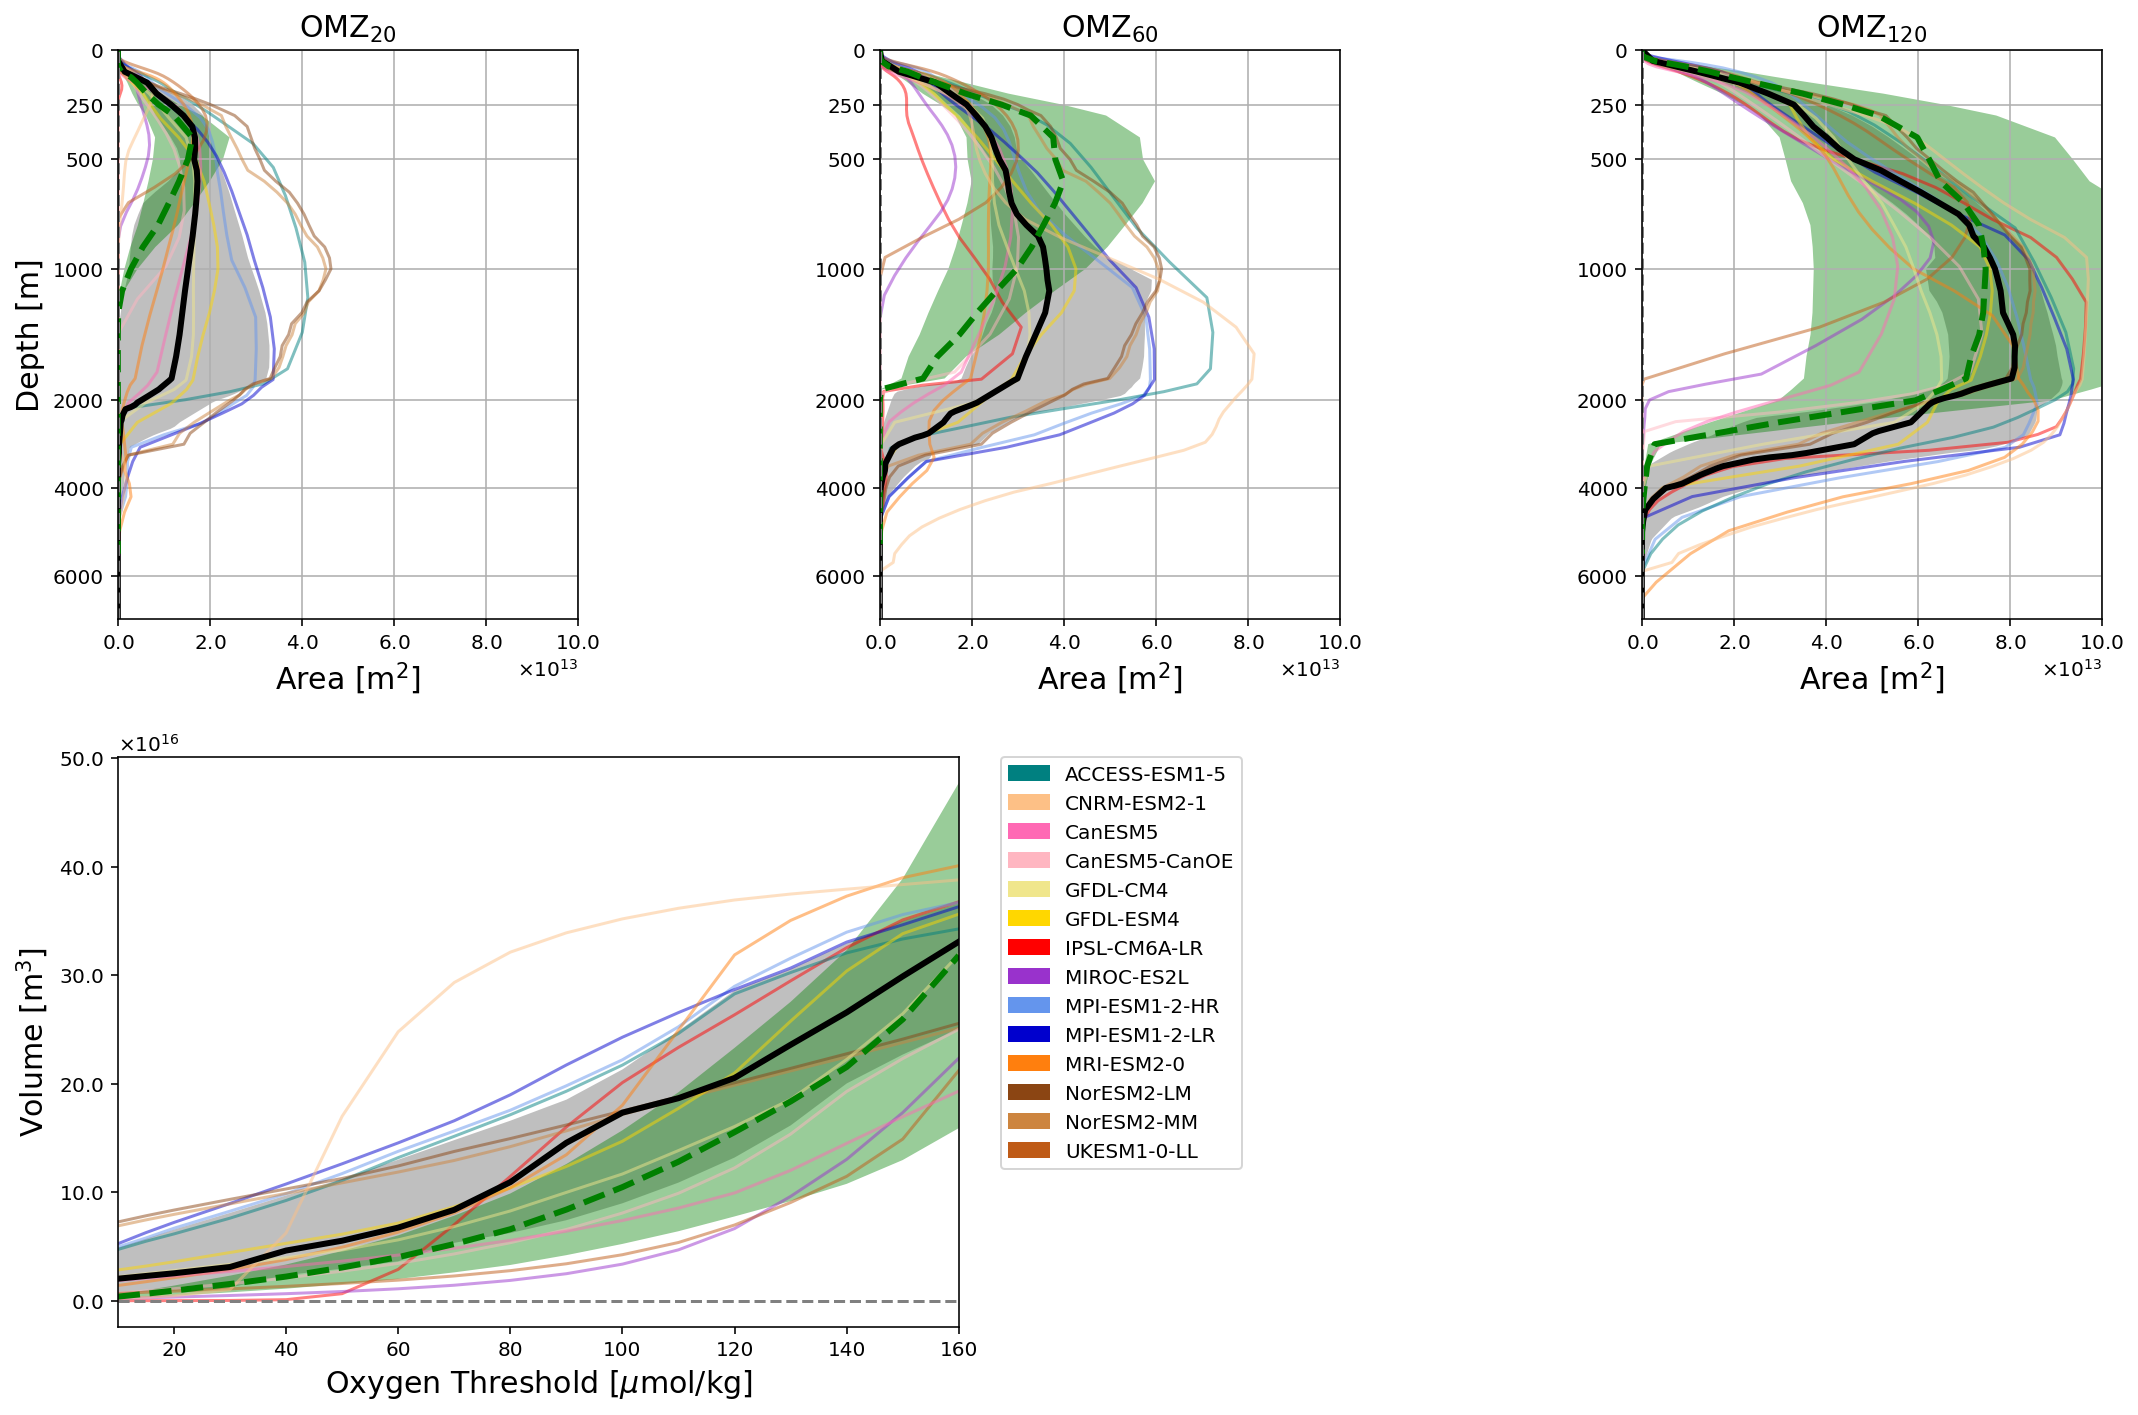

In [12]:
%matplotlib inline
fig = plt.figure(figsize=[15,10])
spec = fig.add_gridspec(ncols=6, nrows=2)
axes = {}
axes['A'] = fig.add_subplot(spec[0, 0:2])
axes['B'] = fig.add_subplot(spec[0, 2:4])
axes['C'] = fig.add_subplot(spec[0, 4:6])
axes['D'] = fig.add_subplot(spec[1, 0:3])


lat_bin = slice(-30,30)

validation_depth_plot(results_historical_volume, obs_historical_volume, 20, lat_bin, axes['A'] )
validation_depth_plot(results_historical_volume, obs_historical_volume, 60, lat_bin, axes['B'] )
validation_depth_plot(results_historical_volume, obs_historical_volume, 120, lat_bin, axes['C'])
axes['B'].set_ylabel('')
axes['C'].set_ylabel('')
axes['A'].set_title(r'$\mathrm{OMZ}_{20}$', fontsize = 15)
axes['B'].set_title(r'$\mathrm{OMZ}_{60}$', fontsize = 15)
axes['C'].set_title(r'$\mathrm{OMZ}_{120}$', fontsize = 15)

validation_oxygen_plot(results_historical_volume, obs_historical_volume, lat_bin, 8000, axes['D'])
axes['D'].set_xlim(10, 160)

plt.tight_layout()

# Figure 3 ab

In [13]:
#for o2 decomposition, calculate time series of difference between value and 1980-2000 mean
def calc_anomolies(ds):

    #compute over OMZ volume gained over 21st century
    o2_gain_anom = ds.o2_gain - ds.o2_gain.sel(time = slice('1980', '2000')).mean(['time'])
    o2sat_gain_anom = ds.o2sat_gain - ds.o2sat_gain.sel(time = slice('1980', '2000')).mean(['time'])
    aou_gain_anom = -ds.aou_gain + ds.aou_gain.sel(time = slice('1980', '2000')).mean(['time'])
    
    #compute over OMZ volume lost over 21st century
    o2_loss_anom = ds.o2_loss - ds.o2_loss.sel(time = slice('1980', '2000')).mean(['time'])
    o2sat_loss_anom = ds.o2sat_loss - ds.o2sat_loss.sel(time = slice('1980', '2000')).mean(['time'])
    aou_loss_anom = -ds.aou_loss + ds.aou_loss.sel(time = slice('1980', '2000')).mean(['time'])
    
    #compute over total volume of change
    o2_anom = (o2_gain_anom*ds.gained_vol + o2_loss_anom*ds.lost_vol) / (ds.gained_vol + ds.lost_vol)
    o2sat_anom = (o2sat_gain_anom*ds.gained_vol + o2sat_loss_anom*ds.lost_vol) / (ds.gained_vol + ds.lost_vol)
    aou_anom = (aou_gain_anom*ds.gained_vol + aou_loss_anom*ds.lost_vol) / (ds.gained_vol + ds.lost_vol)

    return o2_anom, o2sat_anom, aou_anom

In [14]:
#consolidate o2 decomposition results into a single dataset
ds_list = []
for name, ds in results_o2_decomp.items():
    ds_ = ds.sel(time = slice('1980', '2100'))
    ds_list.append(ds_)
ds_o2_decomp = xr.concat(ds_list, dim = 'model')

#calculate changes in o2, o2sat, aou
o2_anom, o2sat_anom, aou_anom = calc_anomolies(ds_o2_decomp)
anom_dict = {'o2_anom':o2_anom, 'o2sat_anom':o2sat_anom, 'aou_anom':aou_anom}

#take trends
trend_dict = {}
for name, da in anom_dict.items(): 
    trend_dict[name] = linear_trend(da.sel(time = slice('2000', '2100')), 'time').slope*101

#average over members
for name,da in trend_dict.items():
    if 'member_id' in list(da.dims):
        trend_dict[name] = da.mean('member_id')

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees

In [15]:
#plot changes in o2, o2sat, aou vs o2 threshold
def oxygen_space_o2_decomp_plot(trend_dict, ax):
    colors = ['orange', 'teal', 'black']
    labels = [r'$\mathrm{O_{2,SAT}}$', '-AOU', r'$\mathrm{O_2}$']
    for i, decomp in enumerate(['o2sat_anom', 'aou_anom', 'o2_anom']):
        ds = trend_dict[decomp]
        
        Median = ds.median('model')
        M1 = ds.quantile(.25, 'model')
        M2 = ds.quantile(.75, 'model')
        
        ax.plot(Median.o2_thresh, Median, color = colors[i], linewidth = 3, label = labels[i])
        ax.fill_between(Median.o2_thresh, M1, M2, alpha = 0.5, color = colors[i], edgecolor = 'none')
        
    ax.axhline(0., color = '0.5', ls='--')
    ax.set_xlim(5,160)
    ax.set_ylabel('Oxygen Trend\n[$\mathrm{\mu mol/kg}$/century]', fontsize = 15)
    ax.set_xlabel(r'Oxygen Threshold [$\mu$mol/kg]', fontsize = 15)
    ax.legend()

    
#Plot integrated OMZ volume trend vs O2 threshold    
def oxygen_space_trend_plot(ddict,lat_bins, lev, ax, models = False):
    colors = o2_model_colors()
    Median_list = []
    o2_range = slice(5, 160)
    ######## PLOT MODEL CURVES ########################
    for name, ds in ddict.items():
        source_id = ds.source_id
        out = ds.slope.sel(lat_bin = lat_bins, o2_bin = o2_range, lev = slice(0,lev)).sum(['lat_bin', 'lev'])
        if models:
            shaded_line_plot(out, 'member_id', line_kwargs=dict(color=colors[source_id]), ax = ax)
        Median_list.append(out.mean(['member_id']))
    ###################################################
    
    ######## PLOT MEDIAN CURVE ########################
    Median = xr.concat(Median_list, 'model').median('model')
    ax.plot(Median.o2_bin, Median, color = 'black', linewidth = 3)
    
    M1 = xr.concat(Median_list, 'model').quantile(.25, dim = 'model')
    M2 = xr.concat(Median_list, 'model').quantile(.75, dim = 'model')
    ax.fill_between(Median.o2_bin, M1, M2, alpha = 0.5, color = 'gray', edgecolor = 'none')
    ###################################################


    ############ FORMATING ###################################
    ax.axhline(0., color = '0.5', ls='--')
    ax_lim_format = 16
    ax.yaxis.set_major_formatter(ScientificManualFormatter(ax_lim_format, "%1.1f"))
    ax.ticklabel_format(
        axis="y", style="sci", scilimits=(-ax_lim_format, ax_lim_format)
    )
    ax.set_xlim(5,160)
    ax.set_ylabel('Volume Trend\n[$\mathrm{m}^3$/century]', fontsize = 15)
    ax.set_xlabel(r'Oxygen Threshold [$\mu$mol/kg]', fontsize = 15)

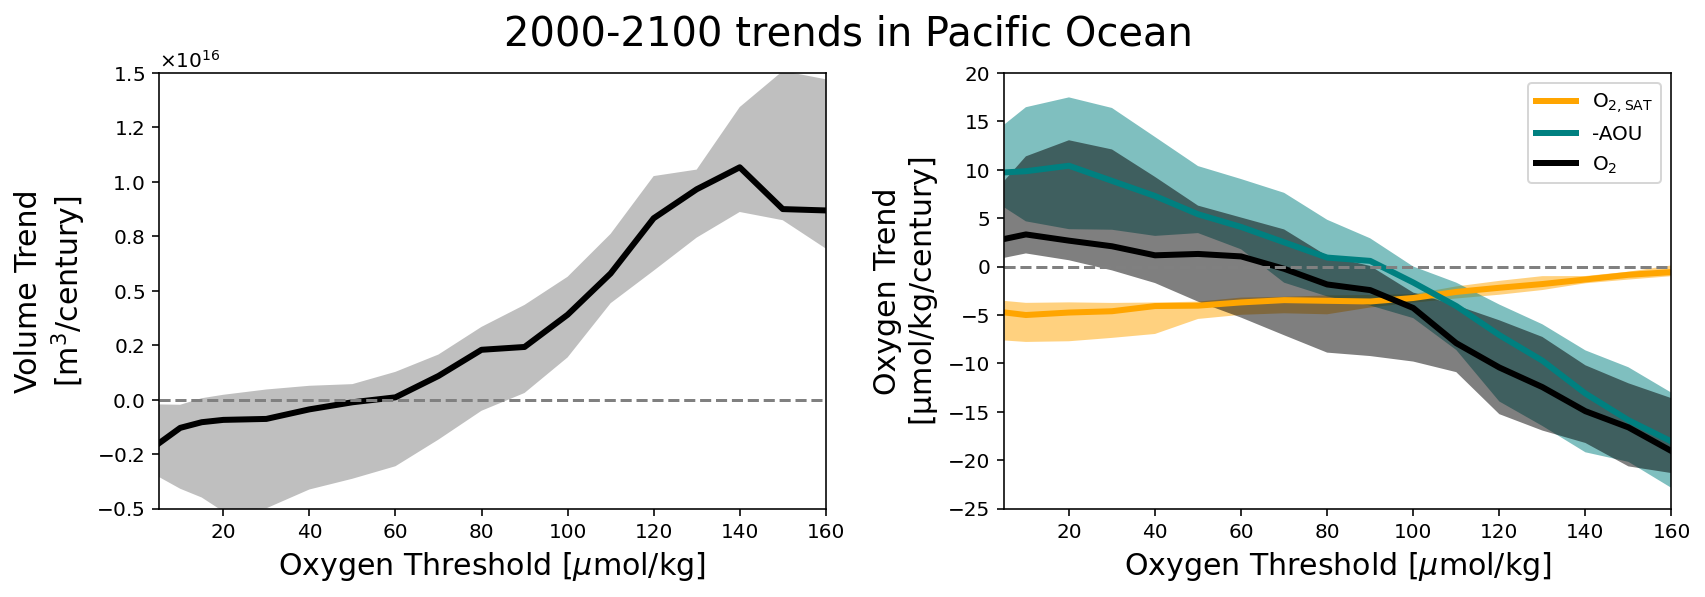

In [16]:
#Figure 3: (a) omz volume trend vs o2 threshold, (b) decomposed o2 trend vs o2 threshold 

%matplotlib inline
fig, axes = plt.subplots(1,2, figsize = [12,4.5])

lat_bin = slice(-30,30)

#validation_oxygen_plot(results_hist_volume, obs_hist, lat_bin, 8000, axes[0])
oxygen_space_trend_plot(results_volume_trend, lat_bin, 8000, axes[0])
oxygen_space_o2_decomp_plot(trend_dict, axes[1])
axes[0].set_ylim(-.5e16, 1.5e16)
axes[1].set_ylim(-25, 20)
axes[0].set_xlim(5, 160)
axes[1].set_xlim(5, 160)
plt.suptitle('2000-2100 trends in Pacific Ocean', fontsize = 20, y = .92)
plt.tight_layout()

In [17]:
ds_list = []
for name, ds in results_vol_ts.items():
    ds_list.append(ds)
ds_vol = xr.concat(ds_list, dim = 'model')

vol_anom = (ds_vol.volume - ds_vol.volume.sel(time = slice('1980', '2000')).mean('time')).mean(['member_id'])

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along

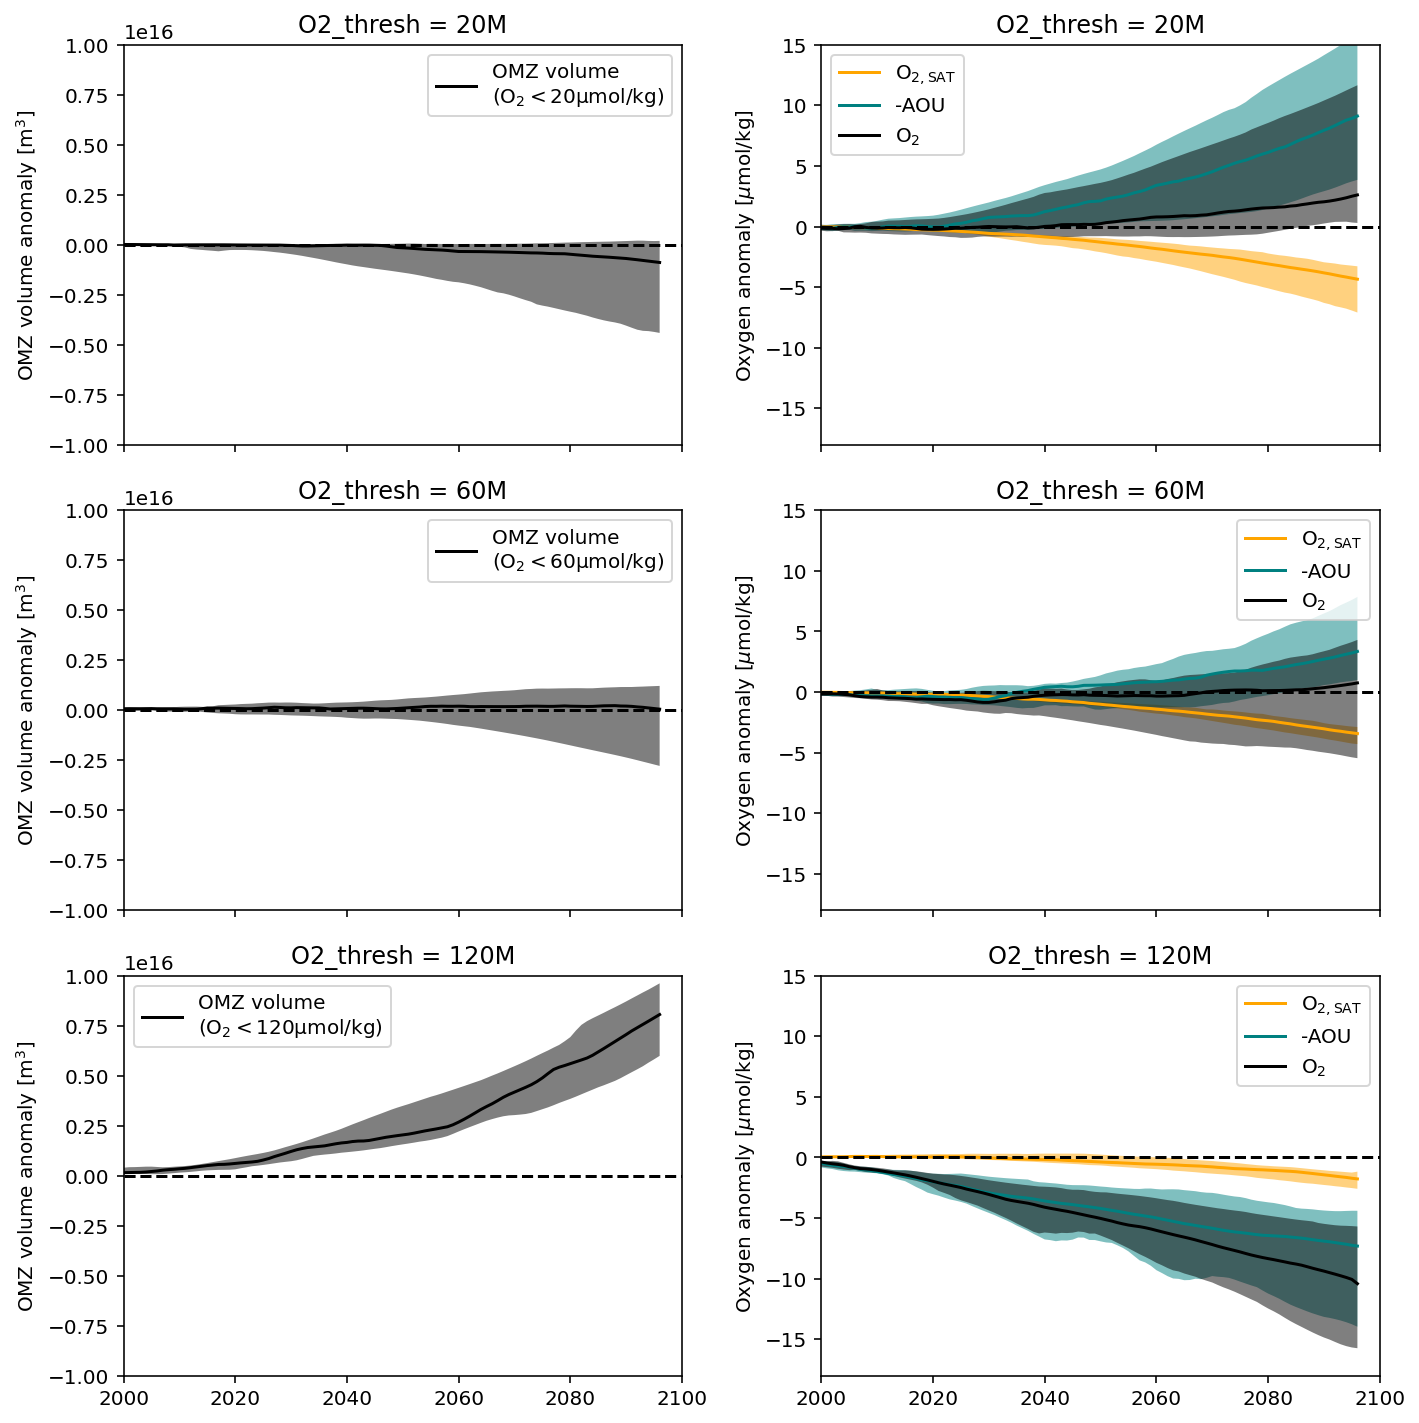

In [18]:
fig, axes = plt.subplots(3,2, figsize = [10, 10], sharex = True)

o2_thresh = [20, 60, 120]
spreadstyle = 'std'
spreads = [1.]
colors = ['orange', 'teal', 'black']
labels = [r'$\mathrm{O_{2,SAT}}$', '-AOU', r'$\mathrm{O_2}$']

for i, o2 in enumerate(o2_thresh):
    Median_vol = vol_anom.sel(o2_bin = o2, method = 'nearest').rolling(time = 10, center = True).mean('time').median(['model'])
    M1_vol = vol_anom.sel(o2_bin = o2, method = 'nearest').rolling(time = 10, center = True).mean('time').quantile(.25, 'model')
    M2_vol = vol_anom.sel(o2_bin = o2, method = 'nearest').rolling(time = 10, center = True).mean('time').quantile(.75, 'model')
    axes[i,0].plot(Median_vol.time, Median_vol, color = 'black', label = 'OMZ volume\n($\mathrm{O_2 < %s \mu mol/kg}$)'%(o2_thresh[i]))
    axes[i,0].fill_between(Median_vol.time, M1_vol, M2_vol, alpha = 0.5, color = 'black', edgecolor = 'none')

    for ii, decomp in enumerate(['o2sat_anom', 'aou_anom', 'o2_anom']):
        ds = anom_dict[decomp].sel(o2_thresh = o2).rolling(time = 10, center = True).mean('time').mean('member_id')
    
        Median = ds.median('model')
        M1 = ds.quantile(.25, 'model')
        M2 = ds.quantile(.75, 'model')
        axes[i,1].plot(Median.time, Median, color = colors[ii], label = labels[ii])
        axes[i,1].fill_between(Median.time, M1, M2, alpha = 0.5, color = colors[ii], edgecolor = 'none')
    

    axes[i,0].set_ylim(-1e16, 1e16)
    axes[i,0].set_xlim(2000, 2100)
    axes[i,0].axhline(0., color = 'black', ls= 'dashed')
    axes[i,0].legend()
    axes[i,0].set_title(f'O2_thresh = {o2_thresh[i]}M')
    axes[i,0].set_ylabel('OMZ volume anomaly [$\mathrm{m}^3$]')
    
    axes[i,1].set_ylim(-18, 15)
    axes[i,1].axhline(0., color = 'black', ls = 'dashed')
    axes[i,1].set_xlim(2000, 2100)
    axes[i,1].legend()
    axes[i,1].set_title(f'O2_thresh = {o2_thresh[i]}M')
    axes[i,1].set_ylabel('Oxygen anomaly [$\mu$mol/kg]')
    plt.tight_layout()

## Figure S5

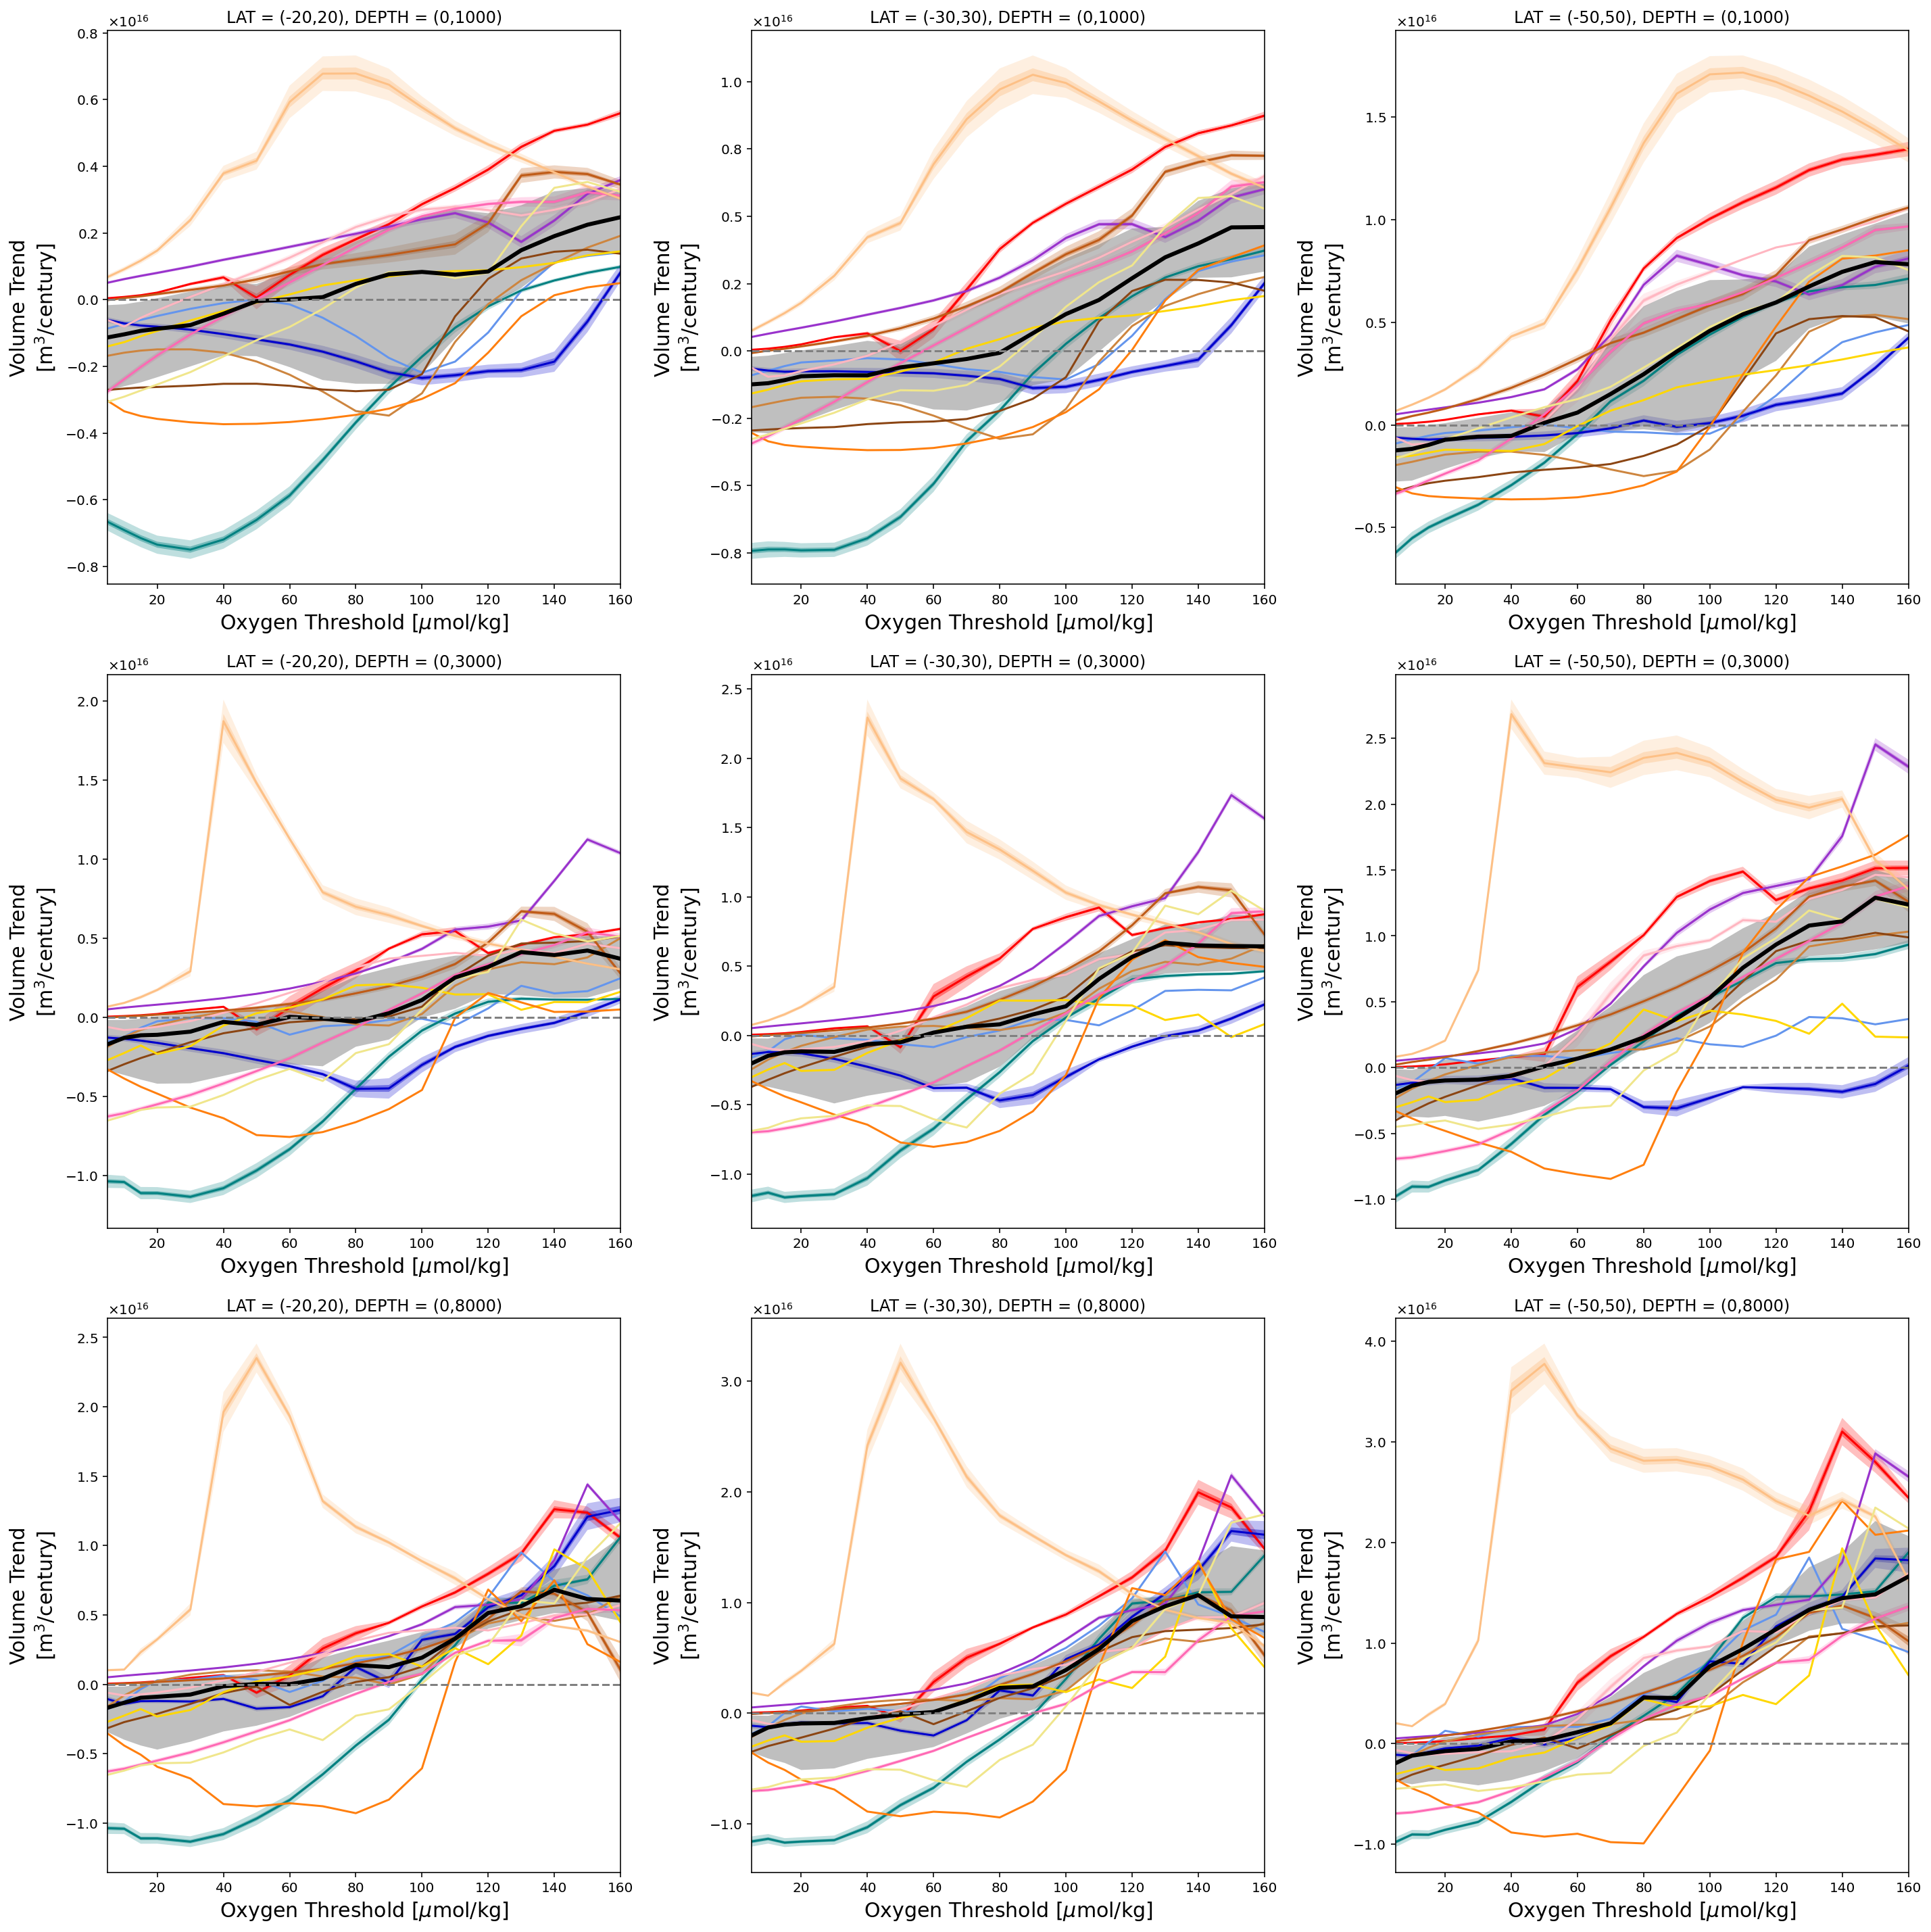

In [19]:
n = 3
m = 3
fig, axes = plt.subplots(n,m, figsize = [20,20])
lev = [1000, 3000, 8000]
lats = [20, 30, 50]

for i in range(m):
    for j in range(n):
        axes[j,i].set_title(f'LAT = (-{lats[i]},{lats[i]}), DEPTH = (0,{lev[j]})')
        oxygen_space_trend_plot(results_volume_trend, slice(-lats[i], lats[i]), lev[j], axes[j,i], models = True)
        
plt.tight_layout()

# Time Series in Figure 6

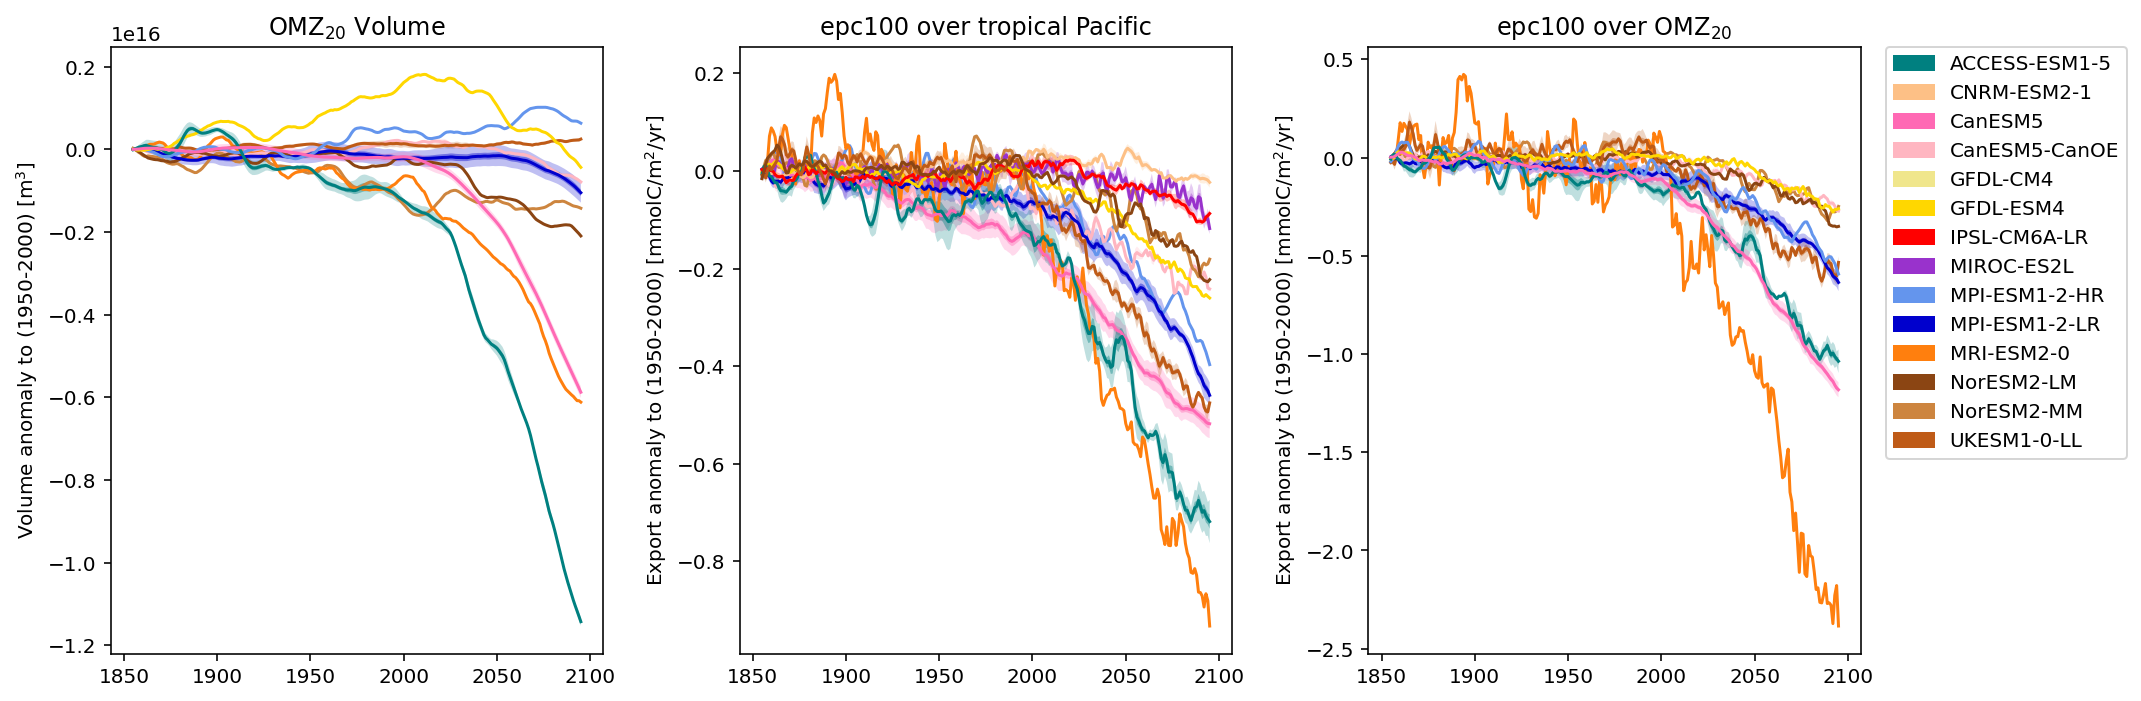

In [20]:
#rolling window size for smoothing
wnd = 10

#convert from s-1 to yr-1
convert_export = (86400)*365.25 #s/day * day/yr

fig, ax = plt.subplots(1,3, figsize = [15, 5])
colors = o2_model_colors()

for name, ds in results_epc_core.items():
    ###########VOLUME TIME SERIES###############
    ax[0].set_ylabel(r'Volume anomaly to (1950-2000) [$\rm{m^3}$]')
    vol_out = (ds.omz_vol - ds.omz_vol.sel(time=slice('1850','1860')).mean(['time']))
    vol_out = vol_out.sel(time = slice('1850', '2100')).rolling(time = wnd, center = True).mean().isel(time=slice(5,-5))
    shaded_line_plot(vol_out, 'member_id',  line_kwargs=dict(color=colors[ds.source_id]), ax = ax[0])

    
    #########EXPORT TIME SERIES ###############
    ax[2].set_ylabel(r'Export anomaly to (1950-2000) [$\rm{mmolC/m^2/yr}$]')
    epc_out = (ds.epc100 - ds.epc100.sel(time=slice('1850','1860')).mean(['time']))*convert_export
    epc_out = epc_out.sel(time = slice('1850', '2100')).rolling(time = wnd, center = True).mean().isel(time=slice(5,-5))
    shaded_line_plot(epc_out, 'member_id', line_kwargs=dict(color=colors[ds.source_id]), ax = ax[2])

for name, ds in results_epc_outer.items():
    #########EXPORT TIME SERIES ###############
    ax[1].set_ylabel(r'Export anomaly to (1950-2000) [$\rm{mmolC/m^2/yr}$]')
    epc_out = (ds.epc100 - ds.epc100.sel(time=slice('1850','1860')).mean(['time']))*convert_export
    epc_out = epc_out.sel(time = slice('1850', '2100')).rolling(time = wnd, center = True).mean().isel(time=slice(5,-5))
    shaded_line_plot(epc_out, 'member_id', line_kwargs=dict(color=colors[ds.source_id]), ax = ax[1])

model_color_legend()

ax[0].set_title('$\mathrm{OMZ_{20}}$ Volume')
ax[1].set_title('epc100 over tropical Pacific')
ax[2].set_title('epc100 over $\mathrm{OMZ_{20}}$')

plt.tight_layout()

# Tables S1, S2, S3

In [21]:
def convert_to_cumulative_volume(hist):
    hist_cumu = hist.cumsum("o2_bin")
    hist_cumu = hist_cumu.assign_coords(o2_bin=hist.o2_bin)
    return hist_cumu
basin_bins = ['North Pacific Ocean','South Pacific Ocean']
lat_bins = slice(-30,30)


ds_obs = convert_to_cumulative_volume(obs_histogram).sel(
    basin_mask_bin = basin_bins, lat_bin = lat_bins).sum(['basin_mask_bin', 'lat_bin', 'lev'])

In [22]:
ddict_tables = {}
for name, ds in results_vol_ts.items():
    ds['trend'] = linear_trend(ds.volume.sel(time = slice('2000', '2100')), 'time').slope.load()*101.
    ds['p_value'] = linear_trend(ds.volume.sel(time = slice('2000', '2100')), 'time').p_value.load()
    ds['hist_vol'] = ds.volume.sel(time=slice('1950','2000')).mean(['time']).load()
    ddict_tables[name] = ds

In [23]:
def make_table(o2_thresh):
    
    obs = ds_obs.volume.sel(o2_bin = o2_thresh, method = 'nearest')
    
    table_dict = {'name': [],
                  '# mem.': [],
                 r'volume ($\rm{m}^3$)':[],
                 'vol. std.':[],
                  'volume (% obs.)': [],
                 r'trend ($\rm{m^3/cen}$)':[],
                 'trend std.':[],
                  'trend (% change)': [],
                'trend p-value':[],
                }
    
    for name, ds in ddict_tables.items():
        ds_ = ds.sel(o2_bin = o2_thresh, method = 'nearest').median(['member_id'])
        
        table_dict['name'].append(ds.source_id)
        table_dict['# mem.'].append(len(ds.member_id))
        table_dict[r'volume ($\rm{m}^3$)'].append(ds_.hist_vol.values)#'{:.2e}'.format(ds_.hist_vol.values))
        table_dict['volume (% obs.)'].append(int(np.rint((ds_.hist_vol/obs).values*100)))
        
        table_dict[r'trend ($\rm{m^3/cen}$)'].append(ds_.trend.values)#'{:.2e}'.format(ds_.trend.values))
        table_dict['trend (% change)'].append(int(np.rint(ds_.trend.values/ds_.hist_vol.values*100)))
        
        if ds.p_value.sel(o2_bin = o2_thresh, method = 'nearest').max(['member_id']).values < 0.05:
            table_dict[r'trend p-value'].append('o')
        else:
            table_dict[r'trend p-value'].append('x')
        
        if len(ds.member_id) > 1:
            table_dict['vol. std.'].append(ds.hist_vol.sel(
            o2_bin = o2_thresh, method = 'nearest').std(['member_id']).values)
            table_dict['trend std.'].append(ds.trend.sel(
            o2_bin = o2_thresh, method = 'nearest').std(['member_id']).values)
        else:
            table_dict['vol. std.'].append('--')
            table_dict['trend std.'].append('--')
    
    DF_models = pd.DataFrame.from_dict(table_dict)
    
    
    #Add Observations
    WOA = {'name': ['WOA'],
                  '# mem.': ['--'],
                 r'volume ($\rm{m}^3$)':obs.values,#['{:.1e}'.format(obs.values)],
                 'vol. std.':['--'],
                  'volume (% obs.)': ['--'],
                 r'trend ($\rm{m^3/cen}$)':['--'],
                 'trend std.':['--'],
                  'trend (% change)': ['--'],
                'trend p-value':['--']
                }
    
    WOA = pd.DataFrame.from_dict(WOA)
    
    
    #Add Multi-model median
    MMM = {'name': ['MMM'],
                  '# mem.': [14],
                 r'volume ($\rm{m}^3$)':[],
                 'vol. std.':[],
                  'volume (% obs.)': [],
                 r'trend ($\rm{m^3/cen}$)':[],
                 'trend std.':[],
                  'trend (% change)': [],
                'trend p-value':['--']
                }
    
    MMM[r'volume ($\rm{m}^3$)'].append(DF_models[r'volume ($\rm{m}^3$)'].median())#'{:.2e}'.format(DF_models[r'volume ($\rm{m}^3$)'].median()))
    MMM['volume (% obs.)'].append(int(np.rint(DF_models['volume (% obs.)'].median())))
    std = np.std(DF_models[r'volume ($\rm{m}^3$)'].values.astype(np.float))
    #MMM['vol. std.'].append('{:.1e}'.format(std))
    MMM['vol. std.'].append('--')
    
    MMM[r'trend ($\rm{m^3/cen}$)'].append(DF_models[r'trend ($\rm{m^3/cen}$)'].median())
    
    #Not sure which method is 'right' here
    #MMM['trend (% change)'].append(int(np.rint(DF_models['trend (% change)'].median())))
    MMM['trend (% change)'].append(int(np.rint(
        DF_models[r'trend ($\rm{m^3/cen}$)'].median()/DF_models[r'volume ($\rm{m}^3$)'].median()*100)))
    
    std = np.std(DF_models[r'trend ($\rm{m^3/cen}$)'].values.astype(np.float))
    #MMM['trend std.'].append('{:.1e}'.format(std))
    MMM['trend std.'].append('--')
    
    MMM = pd.DataFrame.from_dict(MMM)
    
    DF = pd.concat([WOA, MMM, DF_models]).reset_index(drop = True)
    
    return DF

In [24]:
def trunc_display(df):
    
    for i, row in df.iterrows():
        row[r'volume ($\rm{m}^3$)'] = '{:.2f}'.format(float(row[r'volume ($\rm{m}^3$)'])*1e-16)
        if row[r'trend ($\rm{m^3/cen}$)'] != '--':
            row[r'trend ($\rm{m^3/cen}$)'] = '{:.2f}'.format(float(row[r'trend ($\rm{m^3/cen}$)'])*1e-16)
        if row['vol. std.'] != '--':
            row['vol. std.'] = '{:.2f}'.format(float(row['vol. std.'])*1e-16)
        if row['trend std.'] != '--':
            row['trend std.'] = '{:.2f}'.format(float(row['trend std.'])*1e-16)
    return df

In [25]:
#OMZ20
Table = make_table(20)
trunc_display(Table)

/tmp/ipykernel_194866/1044633771.py:73: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std = np.std(DF_models[r'volume ($\rm{m}^3$)'].values.astype(np.float))
/tmp/ipykernel_194866/1044633771.py:84: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std = np.std(DF_models[r'trend ($\rm{m^3/cen}$)'].values.astype(np.float))


,name,# mem.,volume ($\rm{m}^3$),vol. std.,volume (% obs.),trend ($\rm{m^3/cen}$),trend std.,trend (% change),trend p-value
0,WOA,--,1.23,--,--,--,--,--,--
1,MMM,14,2.53,--,205,-0.09,--,-4,--
2,MPI-ESM1-2-LR,10,7.22,0.04,587,-0.08,0.04,-1,x
3,IPSL-CM6A-LR,5,0.01,0.00,1,0.02,0.00,371,o
4,CanESM5-CanOE,3,1.11,0.00,90,-0.10,0.01,-9,o
5,UKESM1-0-LL,5,0.88,0.02,72,0.02,0.01,2,x
6,CNRM-ESM2-1,5,0.49,0.06,39,0.36,0.04,75,o
7,NorESM2-LM,1,8.35,--,679,-0.22,--,-3,o
8,MRI-ESM2-0,1,2.12,--,172,-0.60,--,-28,o
9,CanESM5,20,2.27,0.03,184,-0.66,0.03,-29,o


In [26]:
#OMZ60
Table = make_table(60)
trunc_display(Table)

/tmp/ipykernel_194866/1044633771.py:73: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std = np.std(DF_models[r'volume ($\rm{m}^3$)'].values.astype(np.float))
/tmp/ipykernel_194866/1044633771.py:84: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std = np.std(DF_models[r'trend ($\rm{m^3/cen}$)'].values.astype(np.float))


,name,# mem.,volume ($\rm{m}^3$),vol. std.,volume (% obs.),trend ($\rm{m^3/cen}$),trend std.,trend (% change),trend p-value
0,WOA,--,4.57,--,--,--,--,--,--
1,MMM,14,6.74,--,147,0.01,--,0,--
2,MPI-ESM1-2-LR,10,14.53,0.06,318,-0.18,0.05,-1,o
3,IPSL-CM6A-LR,5,2.91,0.06,64,0.24,0.18,8,o
4,CanESM5-CanOE,3,3.44,0.01,75,0.12,0.02,3,o
5,UKESM1-0-LL,5,1.90,0.06,42,0.13,0.02,7,o
6,CNRM-ESM2-1,5,25.00,0.34,547,2.64,0.16,11,o
7,NorESM2-LM,1,12.42,--,272,-0.10,--,-1,o
8,MRI-ESM2-0,1,6.32,--,138,-0.89,--,-14,o
9,CanESM5,20,4.22,0.04,92,-0.34,0.03,-8,o


In [27]:
#OMZ120
Table = make_table(120)
trunc_display(Table)

/tmp/ipykernel_194866/1044633771.py:73: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std = np.std(DF_models[r'volume ($\rm{m}^3$)'].values.astype(np.float))
/tmp/ipykernel_194866/1044633771.py:84: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  std = np.std(DF_models[r'trend ($\rm{m^3/cen}$)'].values.astype(np.float))


,name,# mem.,volume ($\rm{m}^3$),vol. std.,volume (% obs.),trend ($\rm{m^3/cen}$),trend std.,trend (% change),trend p-value
0,WOA,--,16.95,--,--,--,--,--,--
1,MMM,14,20.53,--,122,0.83,--,4,--
2,MPI-ESM1-2-LR,10,28.65,0.12,169,0.88,0.11,3,o
3,IPSL-CM6A-LR,5,26.48,0.48,156,1.18,0.12,4,o
4,CanESM5-CanOE,3,12.23,0.04,72,0.59,0.03,5,o
5,UKESM1-0-LL,5,7.01,0.42,41,0.79,0.05,11,o
6,CNRM-ESM2-1,5,36.95,0.04,218,1.12,0.09,3,o
7,NorESM2-LM,1,20.08,--,119,0.69,--,3,o
8,MRI-ESM2-0,1,31.87,--,188,1.13,--,4,o
9,CanESM5,20,9.93,0.11,59,0.38,0.04,4,o
